In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd


plt.rcParams.update({
    'font.size': 16,         # Base font size
    'axes.titlesize': 16,    # Title size
    'axes.labelsize': 14,    # X and Y label size
    'xtick.labelsize': 12,   # X tick labels
    'ytick.labelsize': 12,   # Y tick labels
    'legend.fontsize': 12,   # Legend text
    'figure.titlesize': 18   # Figure title
})

In [4]:
def apply_cloud_mask(vegetation_index, SCL, threshold_valid_pixels=0.9):
    '''
    mask_cloud(evi, threshold_cloud=0.9) -> xarray.DataArray
    Mask the VI data based on the SCL (Scene Classification Layer) and a cloud threshold.
    vegetation_index is assumed to be an xarray.DataArray with a 'time' dimension, with vegetation values between 0 and 1, and clouds affect the VI by reducing its value. Typically NDVI, EVI, or similar indices.
    SCL is assumed to be an xarray.DataArray with the same dimensions as vegetation_index.
    threshold_valid_pixels define the acceptable ratio of cloud for an image (the image is kept if the ratio of valid pixels is above this threshold). 
    '''
    mask = xr.ones_like(vegetation_index)  # Default mask (all ones, meaning no masking)

    # keep only pixel valid accordingly to the SCL / can be replaced with a more complex mask
    valid_scl = SCL.isin([4, 5, 6, 7])
    mask = mask.where(valid_scl, np.nan)
    # keep only time steps with more than threshold_cloud% of valid pixels. 
    # This step is important as cloudy images have low quality of EVI values even on area not covered by clouds.
    valid_ratio = valid_scl.sum(
        dim=["x", "y"]
    ) / valid_scl.count(dim=["x", "y"])
    invalid_time_steps = valid_ratio < threshold_valid_pixels
    mask = mask.where(~invalid_time_steps, np.nan)
    return mask * vegetation_index

def compute_max_composite(data, interval_days=10):
        
        def get_time_periods(bin_size, years):
            """Function to generate valid dates (time bins) for all years at once"""
            periods = []
            for year in years:
                bins = np.arange(1, 367, bin_size)
                base_date = datetime(year, 1, 1).date()
                dates = [base_date + timedelta(days=int(d - 1)) for d in bins]
                periods.extend(dates)
            return periods

        
        def get_period_from_timestamp(timestamp, periods):
            """# Define a function to map the timestamp to the corresponding period using searchsorted"""
            period_dates = pd.to_datetime(periods)  # Convert periods to datetime
            # Efficient way to find the period index using searchsorted
            period_index = np.searchsorted(period_dates, timestamp, side="right") - 1
            return period_index

        def get_period_to_time(period_index, periods):
            "# For transforming period back to time (middle of the bin period)"
            start_date = pd.to_datetime(periods[period_index])
            end_date = pd.to_datetime(
                periods[period_index + 1]
                if period_index + 1 < len(periods)
                else periods[period_index]
            )
            midpoint = start_date + (end_date - start_date) / 2
            return midpoint

        # Remove unrealistic values
        data = data.where((data >= 0) & (data <= 1), np.nan)

        # Prepare the periods list (one time-period list for all years in the dataset)
        years = pd.to_datetime(data.time).year.unique()
        periods = get_time_periods(interval_days, years)
        # Map each timestamp to a period
        periods_assigned = [
            get_period_from_timestamp(t, periods) for t in pd.to_datetime(data.time)
        ]

        # Add period as a new dimension to the DataArray
        data.coords["period"] = ("time", periods_assigned)

        # Group by the 'period' and compute max per period
        data_grouped = data.groupby("period")

        # Compute max for each period
        max_per_period = data_grouped.max(dim="time")
        # max_per_period = data_grouped.max(dim="time")

        # Apply the transformation to convert periods back to midpoints in time
        midpoint_times = [
            get_period_to_time(p, periods) for p in max_per_period.coords["period"].values
        ]

        # Update max_per_period with the transformed 'time' coordinates (midpoints)
        max_per_period.coords["time"] = ("period", midpoint_times)
        max_per_period = max_per_period.swap_dims({"period": "time"}).drop_vars(
            "period"
        )
        return max_per_period


def filter_residual_noise(data, noise_half_windows=[1, 2]):
    """Remove local minimal unrealistic with vegetation behavior (strong drop and recovery).

    Args:
        data: (xarray.DataArray): Input data to filter.
        noise_half_windows (list, optional): size of the window left and right to compute the max.
    """
    def remove_local_minima(data, half_window=2):
        """Detect and remove cloud noise using shifted mean values."""
        def _compute_shifted_max(data, window_size, direction=1):
            """Helper function to compute shifted maximum values."""
            max_vals = xr.full_like(data, fill_value=np.nan)  # Initialize with NaNs

            for i in range(1, window_size + 1):
                shifted = data.shift(time=i * direction)

                # Compute element-wise max between max_vals and shifted
                max_vals = xr.where(
                    np.isnan(max_vals),
                    shifted,
                    xr.where(np.isnan(shifted), max_vals, np.maximum(max_vals, shifted)),
                )
            return max_vals

        before_max = _compute_shifted_max(data, half_window, direction=1)
        after_max = _compute_shifted_max(data, half_window, direction=-1)
        is_cloud = (data + 0.05 < before_max) & (data + 0.05 < after_max)
        return xr.where(is_cloud, np.nan, data)
    
    data = data.where((data >= 0) & (data <= 1), np.nan)
    for half_window in noise_half_windows:
        data = remove_local_minima(data, half_window=half_window)
    return data


In [ ]:
# Download and calculate EVI
ds = xr.open_mfdataset('/Net/Groups/BGI/work_3/OEMC/oemc_towers/data/cubes/fluxnet_sentinelhub_tmp/ES-LMa/*.zarr', engine = 'zarr')
# Start from the launch date of both Sentinel-2 satellites (S2A and S2B), 
# when the revisit time drops to 5 days or less, to improve composite quality.
ds = ds.sel(time=slice("2017-03-01", None)) 
evi = (2.5 * (ds.B8A - ds.B04)) / (
            ds.B8A + 6 * ds.B04 - 7.5 * ds.B02 + 1 + 10e-8
        )
evi = evi.chunk({"time": 50, "x": -1, "y":-1})

cloudfree_data = apply_cloud_mask(vegetation_index=evi, SCL=ds.SCL, threshold_valid_pixels=0.8) # SCL is used as cloud mask, can be replaced with a more complex mask. Important point is to remove images where high cloud coverage lead to low quality of EVI values even on area not covered by clouds.
composite = compute_max_composite(cloudfree_data, interval_days=16).compute()
# Optional: filter residual noise due to undetected clouds or other artifacts
clean_data = filter_residual_noise(composite, noise_half_windows=[1, 2]).compute()

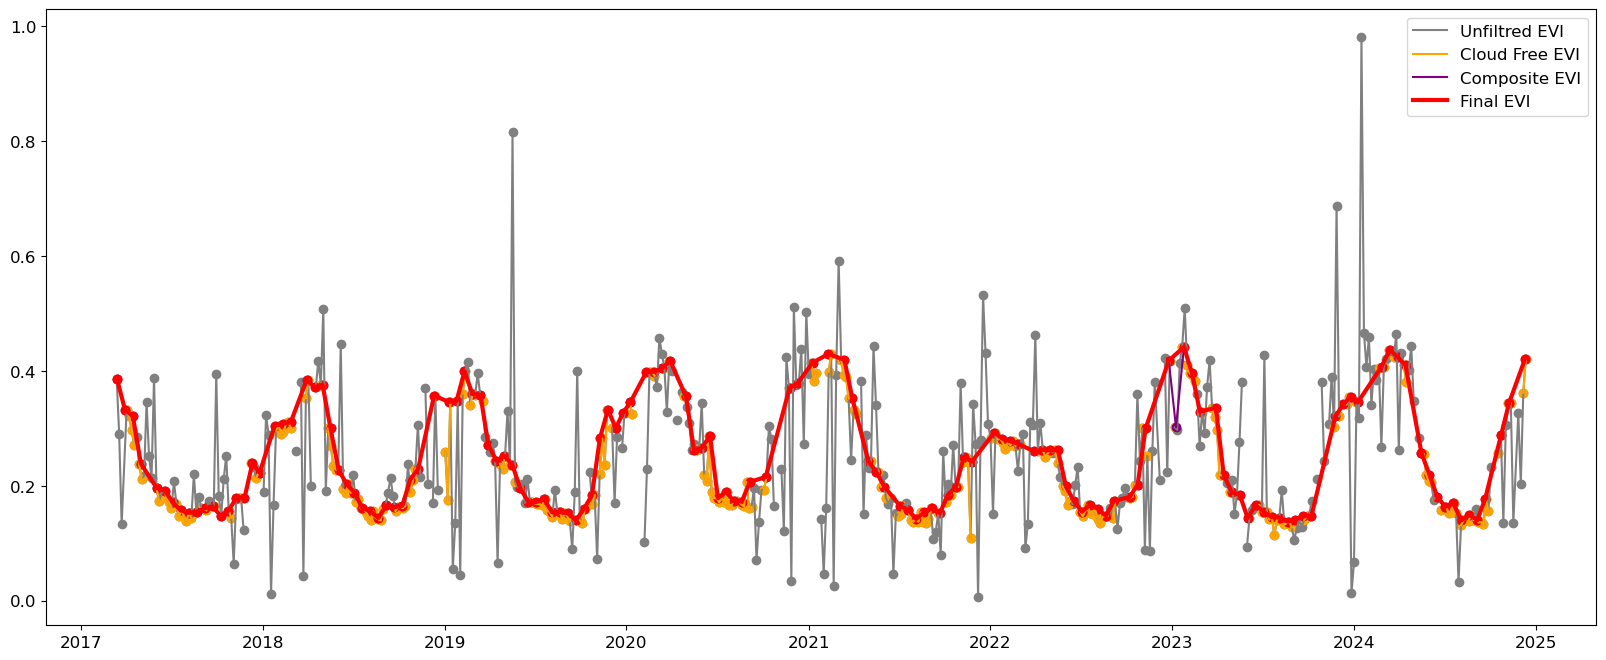

In [8]:
plt.figure(figsize=(20, 8))

evi = evi.where((evi >= 0) & (evi <= 1), np.nan)
plt.plot(evi.isel(x=100, y=10).time, evi.isel(x=100, y=10).values, color="gray", label="Unfiltred EVI")
plt.scatter(evi.isel(x=100, y=10).time, evi.isel(x=100, y=10).values, color="gray")

plt.plot(cloudfree_data.isel(x=100, y=10).time, cloudfree_data.isel(x=100, y=10).values, color="orange",  label="Cloud Free EVI")
plt.scatter(cloudfree_data.isel(x=100, y=10).time, cloudfree_data.isel(x=100, y=10).values, color="orange")

plt.plot(composite.isel(x=100, y=10).time, composite.isel(x=100, y=10).values, color="purple",  label="Composite EVI")
plt.scatter(composite.isel(x=100, y=10).time, composite.isel(x=100, y=10).values, color="purple")

mask_clean = ~np.isnan(clean_data.isel(x=100, y=10)) #.compute()  # remove the nan to have the line of the plot continuous mask to have the next line
plt.plot(clean_data.isel(x=100, y=10)[mask_clean].time, clean_data.isel(x=100, y=10)[mask_clean].values, linewidth=3, color="red", label="Final EVI")
plt.scatter(clean_data.isel(x=100, y=10).time, clean_data.isel(x=100, y=10).values, color="red")

plt.legend()


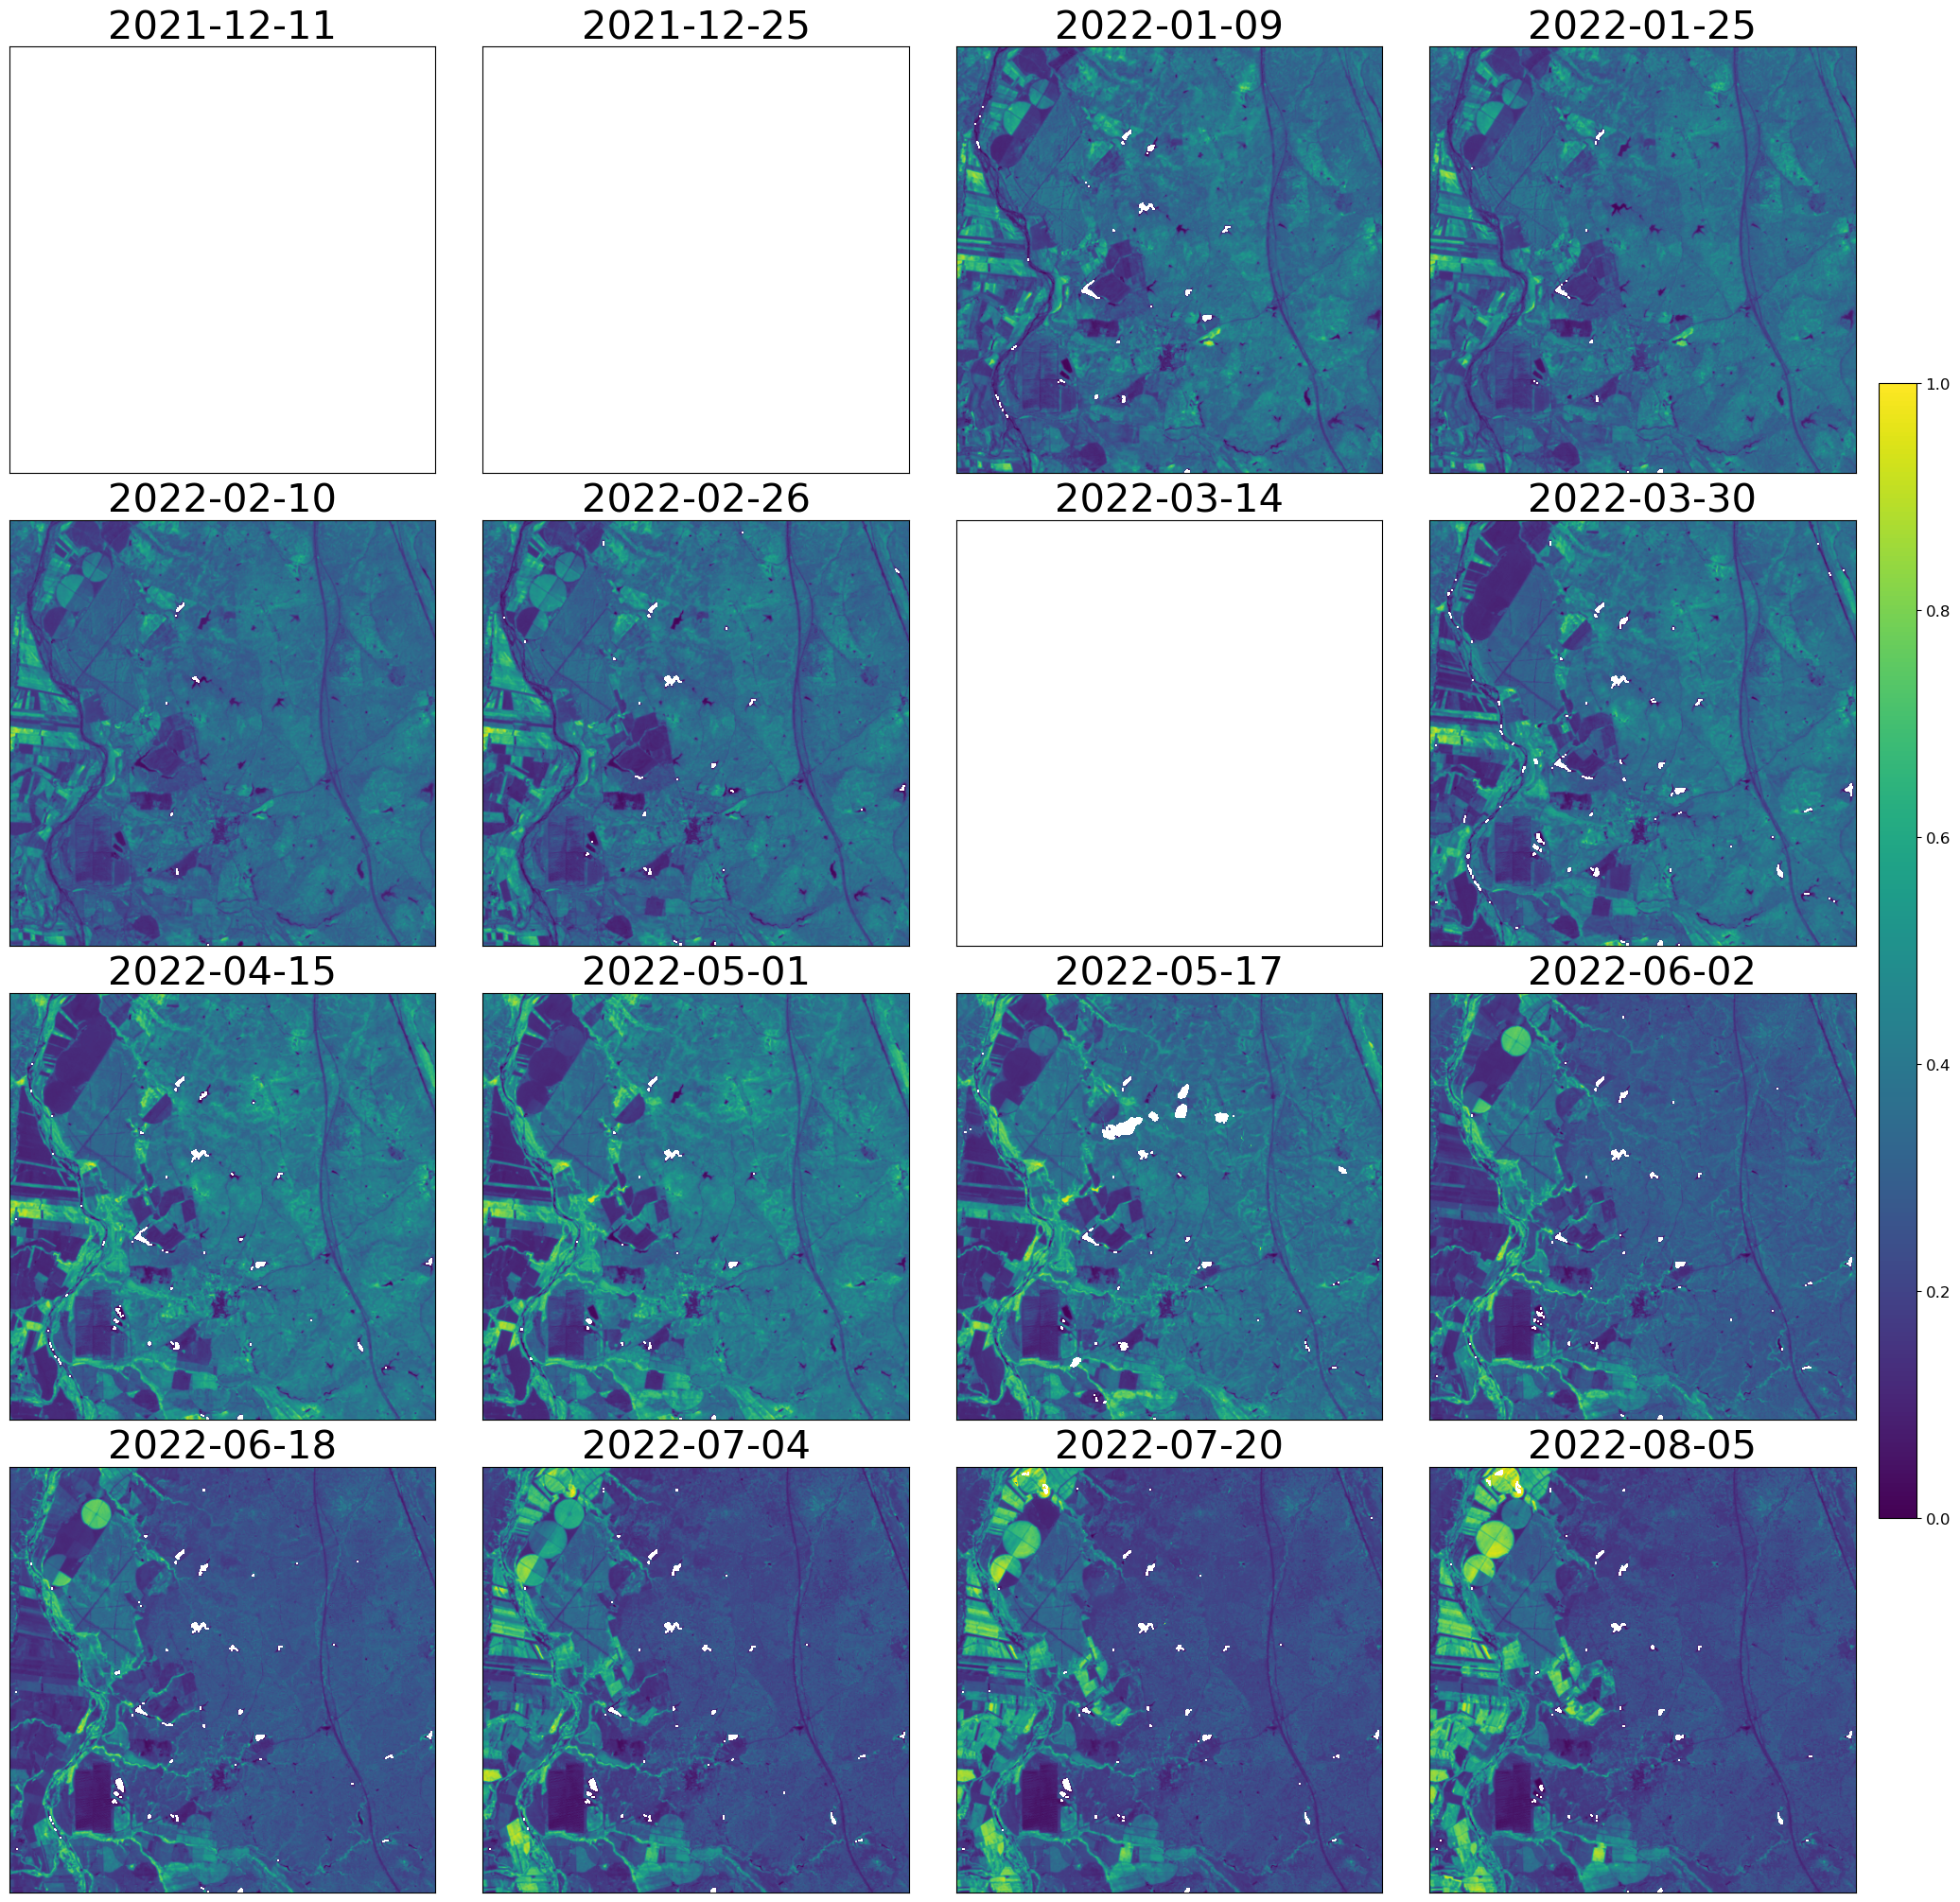

In [9]:
data = composite
fig, axes = plt.subplots(nrows=4, ncols=4, constrained_layout=True, figsize=(20, 20))

t = 110  # 259 + 1
vmin, vmax = 0, 1  # Define color limits

# Create a common colorbar axis
cbar_ax = fig.add_axes([1, 0.2, 0.02, 0.6])  # Position for colorbar

for i in range(4):
    for j in range(4):
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        current_date = data.isel(time=t).time.dt.date.values
        axes[i, j].set_title(str(current_date), fontsize=30)
        data_t = data.isel(time=t).values.T
        
        im = axes[i, j].imshow(data_t, vmin=vmin, vmax=vmax, cmap="viridis")  # Apply consistent colormap
        t += 1

# Add a single colorbar
fig.colorbar(im, cax=cbar_ax)

plt.show()